In [690]:
from importlib import reload
import numpy as np
from numpy import transpose, trace, multiply, power, dot
from numpy.linalg import multi_dot, matrix_power, norm
import scipy.stats as ss
from scipy.special import comb
from sklearn.cluster import KMeans
import math
import pandas as pd
import itertools
import time
from tqdm import tqdm
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pickle
from TracyWidom import TracyWidom
import data_gen as dg
import stat_test as st
import visualizations as viz

In [691]:
# Reload modules in case of modifications
reload(dg)
reload(st)
reload(viz)

<module 'visualizations' from '/Users/louiscam/Dropbox (MIT)/SBMtesting/Simulations-Python/visualizations.py'>

# Setting, parameters and data

In [598]:
# Test parameters
level = 0.05

In [599]:
# Simulation parameters
N_rep = 100

In [581]:
# Model parameters for 2-community SBM
n = 500
K = 2
a = np.array([0.4,0.6])
r = 0.1
P = r*np.array([[2,0.1],[0.1,2]])

# # Model parameter for Erdos-Renyi model
# n = 500
# K = 1
# a = np.array([1])
# r = 0.1
# P = r*np.array([[6]])

In [582]:
# Generate data from SBM
np.random.seed(13)
data = []
for _ in tqdm(range(N_rep)):
    # Construct Pi
    pi_mat = np.random.multinomial(n=1, pvals=a, size=n)
    # Construct Omega
    Omega = multi_dot([pi_mat, P, transpose(pi_mat)])
    # Sample adjacency matrix
    bern_vars = np.random.binomial(n=1, p=Omega)
    tri = np.triu(bern_vars, k=1)
    adj = tri+transpose(tri)
    data.append(adj)
data = np.array(data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.27it/s]


# Check PET

In [515]:
# Run PET on data, report estimated power
power_PET = 0
for c in tqdm(range(N_rep)): 
    A = data[c,:,:]
    power_PET += st.PET_test(A, level)['reject']
power_PET = power_PET/N_rep
print(f'Empirical power of PET = {power_PET}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.22it/s]

Empirical power of PET = 1.0


# Check eigenvalue-based test

In [516]:
# Run test of Lei (2016) on data, report estimated power
reload(st)
K0 = 1
power_lei = 0
for c in tqdm(range(N_rep)): 
    A = data[c,:,:]
    power_lei += st.lei_test(A, K0, level)['reject']
power_lei = power_lei/N_rep
print(f'Empirical power of Lei test = {power_lei}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]

Empirical power of Lei test = 1.0


# Check Likelihood Ratio criterion of Wang & Bickel (2016)

In [583]:
# Run model selection approach of Wang & Bickel (2016) on data, report estimated power
Kmax = 2
power_wang = 0
for c in tqdm(range(N_rep)): 
    A = data[c,:,:]
    power_wang += st.wangbickel_likelihood_method(A, Kmax, tol=1e-8, tol_fp=1e-4, max_iter=100, seed=13)['reject']
power_wang = power_wang/N_rep
print(f'Empirical power of Wang & Bickel test = {power_wang}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]

Empirical power of Wang & Bickel test = 1.0


# Reproduce Figure 3(a) of Bickel and Wang


In [667]:
# Model parameter for Erdos-Renyi model
N_rep = 50
n = 500
K = 2
a = np.array([0.4,0.6])
r_list = np.arange(0.02, 0.4, 0.02)
S = np.array([[2,1],[1,2]])

In [668]:
# Compute fraction of correct K
np.random.seed(14)
Kmax = 2
frac_K = []
for r in r_list:
    print(f'Process r={r}')
    
    # Define P
    P = r*S
    
    # Generate data from SBM
    data = []
    for _ in range(N_rep):
        # Construct Pi
        pi_mat = np.random.multinomial(n=1, pvals=a, size=n)
        # Construct Omega
        Omega = multi_dot([pi_mat, P, transpose(pi_mat)])
        # Sample adjacency matrix
        bern_vars = np.random.binomial(n=1, p=Omega)
        tri = np.triu(bern_vars, k=1)
        adj = tri+transpose(tri)
        data.append(adj)
    data = np.array(data)
    
    # Model selection
    power_wang = 0
    for c in tqdm(range(N_rep)): 
        A = data[c,:,:]
        power_wang += st.wangbickel_likelihood_method(A, Kmax, tol=1e-8, tol_fp=1e-4, max_iter=100, seed=13)['reject']
    power_wang = power_wang/N_rep
    frac_K.append(power_wang)
frac_K = np.array(frac_K)

Process r=0.02


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [8:48:43<00:00, 634.47s/it]


Process r=0.04


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [13:48<00:00, 16.58s/it]


Process r=0.06


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.47it/s]


Process r=0.08


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.10it/s]


Process r=0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


Process r=0.12000000000000001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.21it/s]


Process r=0.13999999999999999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


Process r=0.16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]


Process r=0.18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.66it/s]


Process r=0.19999999999999998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.45it/s]


Process r=0.22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.41it/s]


Process r=0.24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.66it/s]


Process r=0.26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.10it/s]


Process r=0.28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.62it/s]


Process r=0.30000000000000004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.51it/s]


Process r=0.32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.39it/s]


Process r=0.34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.23it/s]


Process r=0.36000000000000004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


Process r=0.38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.56it/s]


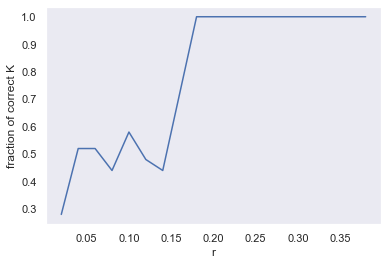

In [669]:
# Plot Figure 3 of Bickel and Wang
plt.figure()
plt.plot(r_list, frac_K)
plt.xlabel('r')
plt.ylabel('fraction of correct K')
plt.show()

In [671]:
frac_K

array([0.28, 0.52, 0.52, 0.44, 0.58, 0.48, 0.44, 0.72, 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [692]:
# Model parameter for Erdos-Renyi model
N_rep = 1000
n = 500
K = 2
a = np.array([0.4,0.6])
r_list = np.arange(0.04, 0.4, 0.02)
S = np.array([[2,1],[1,2]])

In [693]:
# Compute fraction of correct K
np.random.seed(14)
Kmax = 2
frac_K = []
for r in r_list:
    print(f'Process r={r}')
    
    # Define P
    P = r*S
    
    # Generate data from SBM
    data = []
    for _ in range(N_rep):
        # Construct Pi
        pi_mat = np.random.multinomial(n=1, pvals=a, size=n)
        # Construct Omega
        Omega = multi_dot([pi_mat, P, transpose(pi_mat)])
        # Sample adjacency matrix
        bern_vars = np.random.binomial(n=1, p=Omega)
        tri = np.triu(bern_vars, k=1)
        adj = tri+transpose(tri)
        data.append(adj)
    data = np.array(data)
    
    # Model selection
    power_wang = 0
    for c in tqdm(range(N_rep)): 
        A = data[c,:,:]
        power_wang += st.wangbickel_likelihood_method(A, Kmax, tol=1e-8, tol_fp=1e-4, max_iter=100, seed=13)['reject']
    power_wang = power_wang/N_rep
    frac_K.append(power_wang)
frac_K = np.array(frac_K)

Process r=0.04


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [39:09<00:00,  2.35s/it]


Process r=0.06


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:50<00:00,  1.31s/it]


Process r=0.07999999999999999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:47<00:00,  1.41it/s]


Process r=0.09999999999999999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:11<00:00,  2.03it/s]


Process r=0.12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:49<00:00,  2.44it/s]


Process r=0.13999999999999999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:44<00:00,  2.90it/s]


Process r=0.15999999999999998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:17<00:00,  3.15it/s]


Process r=0.18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:56<00:00,  3.37it/s]


Process r=0.19999999999999998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:49<00:00,  3.46it/s]


Process r=0.21999999999999997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.74it/s]


Process r=0.23999999999999996


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:05<00:00,  4.07it/s]


Process r=0.25999999999999995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:58<00:00,  4.19it/s]


Process r=0.27999999999999997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.46it/s]


Process r=0.29999999999999993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.39it/s]


Process r=0.31999999999999995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.44it/s]


Process r=0.3399999999999999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:27<00:00,  4.82it/s]


Process r=0.35999999999999993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:26<00:00,  4.83it/s]


Process r=0.37999999999999995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:15<00:00,  5.12it/s]


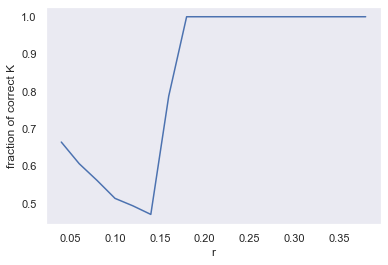

In [694]:
# Plot Figure 3 of Bickel and Wang
plt.figure()
plt.plot(r_list, frac_K)
plt.xlabel('r')
plt.ylabel('fraction of correct K')
plt.show()

In [695]:
frac_K

array([0.664, 0.606, 0.561, 0.513, 0.493, 0.47 , 0.787, 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ])